Read CelebA dataset

In [1]:
!gdown --id 1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW

Downloading...
From: https://drive.google.com/uc?id=1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:11<00:00, 128MB/s]


In [2]:
!unzip -q img_align_celeba.zip -d data

replace data/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


In [3]:
!pip install torchsummary
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl

In [4]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl (145.0 MB)


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
#import torchsummary
from time import sleep
import scipy

In [6]:
image_names = os.listdir('../content/data/img_align_celeba')
print(len(image_names))

training_terminating_idx = int(0.9 * len(image_names))
train_img_list = image_names[:training_terminating_idx]
val_img_list = image_names[training_terminating_idx:]
print('training: ', len(train_img_list))
print('validation: ', len(val_img_list))

202599
training:  182339
validation:  20260


In [7]:
class DatasetAnime(Dataset):
    
  def __init__(self,img_list,image_dir, transform=None):
    self.transform = transform
    self.image_dir = image_dir
    self.img_list = img_list
          
  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, index):
    img_path = self.image_dir + self.img_list[index]
    image = Image.open(img_path).convert('RGB')
    label = Image.open(img_path).convert('RGB')
    image = image.resize((64,64))
    label = label.resize((64,64))
    #image = image.resize((256,256))
    #label = label.resize((256,256))
    image = np.asarray(image, dtype=np.float32)/255
    label = np.asarray(label, dtype=np.float32)/255
    image = torch.from_numpy(image)
    label = torch.from_numpy(label)
    image = image.permute(2,0,1) # channel * width * height
    label = label.permute(2,0,1)
    return image, label


Split the dataset into training dataset and validation. (10% for validation)

In [8]:
train_dataset=DatasetAnime(train_img_list, '../content/data/img_align_celeba/')
val_dataset = DatasetAnime(val_img_list, '../content/data/img_align_celeba/')

In [9]:
def show_samples(batch_tensor,n_row):
  grid = torchvision.utils.make_grid(batch_tensor, nrow=n_row)
  plt.imshow(grid.permute(1, 2, 0).detach().cpu())

torch.Size([3, 64, 64])


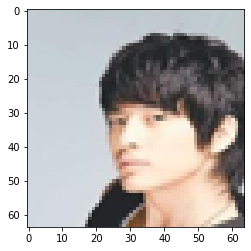

In [10]:
sample_torch_img, _ = train_dataset[121]
sample_single_batch = torch.reshape(sample_torch_img, (1, *sample_torch_img.shape))
print(sample_torch_img.shape)
show_samples(sample_single_batch, 1)

In [11]:
class ProgressBar:
    def __init__(self, total_dt, tabs):
        self.total_data = total_dt
        self.done_data = 0
        self.printed = 0
        
        self.tabs = tabs
        self.to_backspace = 0
    
    def print_init(self):
        print('-' * self.tabs)
    
    # the extra info thing works on my local machine but not here, 
    #  maybe have something to do with how kaggle console deals with flush and backspace
    def update(self, num, extra_info=None):
        if self.to_backspace > 0:
            back_str = '\b' * self.to_backspace
            print(back_str, end='', flush=True)
            self.to_backspace = 0
        self.done_data += num
        while self.printed < int((self.done_data / self.total_data) * self.tabs):
            print('>', end='', flush=True)
            self.printed += 1
        
        if extra_info is not None:
            extra_info = str(extra_info)  # nothing should go multi-line though
            print(extra_info, end='', flush=True)
            self.to_backspace = len(extra_info)

# Model
Reference paper: https://arxiv.org/pdf/2007.03898.pdf


In [12]:
class DownsampleResidualConv(torch.nn.Module):
  # downsample ratio set to two just for simplicity, and residue is done through summation
  def __init__(self, channels, out_channels, dropout_rate=0.1):
    super().__init__()
    self.conv = torch.nn.utils.spectral_norm(
                  torch.nn.Conv2d(
                    channels, 
                    out_channels=out_channels,
                    kernel_size= 3, 
                    stride= 2, 
                    padding = 1
                ))
    self.batch_norm = torch.nn.BatchNorm2d(out_channels)
    self.dropout = torch.nn.Dropout(p=dropout_rate)
    self.activation = torch.nn.LeakyReLU()
    self.downsample = torch.nn.MaxPool2d((4, 4), stride=2, padding=1, dilation=1)

  def forward(self, x):
    result = self.conv(x)
    result = self.batch_norm(result)
    result = self.dropout(result)
    result = self.activation(result)
    
    down_x = self.downsample(x)
    residual_result = torch.cat((result, down_x), dim=1)
    return result, residual_result


# similar to DownsampleResidualConv except it upsamples by a factor of 2
# residual strategy can be both concatenation or addition
class UpsampleResidualConv(torch.nn.Module):
  res_strategies = ['concat', 'add']

  def __init__(self, channels, out_channels, res_strategy='concat', dropout_rate=0.1):
    super().__init__()
    self.conv = torch.nn.utils.spectral_norm(
                  torch.nn.Conv2d(
                    channels, 
                    out_channels=out_channels,
                    kernel_size= 3, 
                    stride= 1, 
                    padding = 1
                ))
    self.batch_norm = torch.nn.BatchNorm2d(out_channels)
    self.dropout = torch.nn.Dropout(p=dropout_rate)
    self.activation = torch.nn.LeakyReLU()
    self.upsample = torch.nn.Upsample(scale_factor=2)
    
    if res_strategy not in self.res_strategies:
      raise ValueError('residual strategy can only be among {0}'.format(','.join(self.res_strategies)))
    self.res_strategy = res_strategy

  def forward(self, x):
    result = self.conv(x)
    result = self.batch_norm(result)
    result = self.dropout(result)
    result = self.activation(result)
    result = self.upsample(result)

    x_up = self.upsample(x)

    if self.res_strategy == 'concat':
      residual_result = torch.cat((result, x_up), dim=1)
    elif self.res_strategy == 'add':
      residual_result = result + x_up
    else:
      raise ValueError('residual strategy can only be among {0}'.format(','.join(self.res_strategies)))
    return residual_result


# a layer to sample a random Gaussian vector based on the input and provided relative mean and var
# first based on the input x (a 1-D vector) and output a sample delta mean and variance (log taken for computational purpose) 
#  then the sample mean = delta mean + mean relative to, sample variance = delta variance * variance relative to
# then sample a random Gaussian vector based on sample mean and variance
# return the sample, the sample distribution, and delta to the previous distribution, for convenience of calculation
# note the linear layers to predict delta means and variances are spectral normalized, based on paper's suggestions
class SampleLayer(torch.nn.Module):
  def __init__(self, input_dim, output_dim, internal_layers=2, dropout_rate=0.1):
    super().__init__()

    def construct_sequential_list():
      inpt = input_dim

      seq_lst = []
      for internal_lyr in range(0, internal_layers - 1):
        otpt = min([(internal_layers - internal_lyr) * output_dim, (inpt + output_dim) // 2])
        seq_lst.extend([
          torch.nn.utils.spectral_norm(
            torch.nn.Linear(
              inpt,
              otpt
            )
          ),
          torch.nn.BatchNorm1d(otpt),
          torch.nn.Dropout(p=dropout_rate),
          torch.nn.LeakyReLU()
        ])
        inpt = otpt

      seq_lst.append(torch.nn.utils.spectral_norm(torch.nn.Linear(inpt, output_dim)))
      seq_lst.append(torch.nn.Dropout(p=dropout_rate))
      return seq_lst
    self.mean_ln = torch.nn.Sequential(*construct_sequential_list()) 
    self.logvar_ln = torch.nn.Sequential(*construct_sequential_list()) 
    
  def forward(self, x, rel_mu, rel_logvar):
    sample_delta_center, sample_delta_logvar = self.mean_ln(x), self.logvar_ln(x)
    sample_center, sample_logvar = rel_mu + sample_delta_center, rel_logvar + sample_delta_logvar
    sample_base = torch.normal(torch.zeros(sample_center.shape), torch.ones(sample_logvar.shape)).to(x.device)

    sampled_result = sample_center + sample_base * torch.exp(sample_logvar * 0.5)
    return sampled_result, sample_center, sample_logvar, sample_delta_center, sample_delta_logvar
    

# encoder part, takes in an image, and returns z_1, ..., z_n (n is configurable by hidden_layers), it also returns the
#  underlying distributions of z_1, ..., z_n to use in calculation of loss during the training
# simulates P[z_n, ..., z_1 | I] in the paper
class BiEncoder(torch.nn.Module):
  def __init__(self, img_size, hidden_size, hidden_layers, encoding_size, encoding_layers=None, img_channels=3, dropout_rate=0.01):
    super().__init__()
    if encoding_layers is None:
      encoding_layers = hidden_layers
    encoding_layers = min((encoding_layers, hidden_layers))

    self.width, self.height = img_size
    self.img_channels = img_channels

    self.hidden_size = hidden_size

    self.encoding_size = encoding_size
    self.encoding_layers = encoding_layers

    w, h = self.width, self.height
    residual_down_lst = []
    backward_sample_net_lst = []
    forward_sample_net_lst = []
    in_channels = self.img_channels
    for lyr in range(0, hidden_layers):
      w, h = w//2, h//2
      
      # image features to use to predict hidden variables, see forward function for its usuage
      residual_down_lst.append(DownsampleResidualConv(in_channels, self.hidden_size, dropout_rate=dropout_rate))
      backward_sample_net_lst.append(SampleLayer(self.hidden_size * w * h, self.encoding_size, internal_layers=2, dropout_rate=dropout_rate))

      if lyr > 0:
        forward_sample_net_lst.append(SampleLayer(self.encoding_size, self.encoding_size, internal_layers=2, dropout_rate=dropout_rate))

      in_channels += self.hidden_size

    # residual models to, based on image, predict z_i backwards from z_n to z_1 (that is, P[z_{i-1} | z_i])
    # both in the order of z_n, z_{n-1}, ..., z_1
    self.backward_modules = torch.nn.ModuleList(residual_down_lst)
    self.backward_sample_modules = torch.nn.ModuleList(backward_sample_net_lst)

    # P[z_i | z_{i-1}]
    # in order of z_2, ..., z_n
    self.forward_sample_modules = torch.nn.ModuleList(forward_sample_net_lst)

    self.z1_concat_vec = torch.nn.Parameter(torch.zeros(self.encoding_size))

  # takes in the image as the input.
  def forward(self, x, hint=0.0):
    residual_conv_input = x
    backward_results = []

    # go through the backward model, first form I_n, ..., I_1 in the order of I_{n+1} => I_n => ... => I_1 where I_{n+1} is input image
    for lyr in range(0, len(self.backward_modules)):
      output_i, res_output_i = self.backward_modules[lyr](residual_conv_input)

      backward_results.append(output_i)
      residual_conv_input = res_output_i
      # print(output_i.shape)

    prev_z = torch.stack(tuple([self.z1_concat_vec for _ in range(0, x.shape[0])]), dim=0)
    base_mu = torch.zeros(self.encoding_size).to(x.device)
    base_logvar = torch.zeros(self.encoding_size).to(x.device)

    # this time backward
    hidden_vars_backward = []
    mu_lst = []
    logvar_lst = []
    dmu_lst = []
    dlogvar_lst = []

    # now based on I_n, ...., I_1, sample z_n, ..., z_1
    for lyr in range(0, self.encoding_layers):
      mu_lst.append(base_mu)
      logvar_lst.append(base_logvar)

      gen_input_i = torch.flatten(backward_results[-lyr - 1], start_dim=1)
      # gen_input_i = torch.cat((gen_input_i, prev_z), dim=1)
      z_i, mu, logvar, dmu, dlogvar = self.backward_sample_modules[-lyr - 1](gen_input_i, base_mu, base_logvar)

      hidden_vars_backward.append(z_i)

      base_mu = mu
      base_logvar = logvar

      dmu_lst.append(dmu)
      dlogvar_lst.append(dlogvar)
      
      prev_z = z_i

    # using the generated z_1, form forward encoding using z_2', ..., z_n'
    hidden_vars_forward, mu_lst_foward, logvar_lst_forward, dmu_lst_forward, dlogvar_lst_forward = self.get_forward_encodings(
        hidden_vars_backward[0],
        mu_lst[1] if self.encoding_layers >= 2 else None,
        logvar_lst[1] if self.encoding_layers >= 2 else None
    )

    mu_lst.extend(mu_lst_foward)
    logvar_lst.extend(logvar_lst_forward)
    dmu_lst.extend(dmu_lst_forward)
    dlogvar_lst.extend(dlogvar_lst_forward)

    # if training mode, take a random weighted mean for the z and z', and if evaluating, mix it in the hint coefficient given
    #  for the weight of backward z (idea is that z used the full info from the image while z' only knows the bottom level
    #  info)
    hidden_vars_coefficient = [
      torch.rand(h_b.shape).to(h_b.device) if self.training else hint for h_b in hidden_vars_backward
    ]

    hidden_vars = [
      h_b * c + (1-c) * h_f for h_b, h_f, c in zip(
        hidden_vars_backward, 
        hidden_vars_forward, 
        hidden_vars_coefficient
      )
    ]
    
    forward_backward_diffs = torch.tensor(torch.cat(hidden_vars_backward).detach().cpu().numpy()).to(x.device) - torch.cat(hidden_vars_forward) 

    # return the final hidden variables, and also their distributions for loss computations. we also want z' to approximate z
    #  so also return difference between z and z', but we treat z as ground truth so the diff is not differentiable in respect
    #  to z
    return hidden_vars, mu_lst, logvar_lst, dmu_lst, dlogvar_lst, forward_backward_diffs

  # apply the forward models to form the encodings based on z_1
  def get_forward_encodings(self, z_1, base_mu=None, base_logvar=None):
    if base_mu is None:
      base_mu = torch.zeros(self.encoding_size).to(z_1.device)
    if base_logvar is None:
      base_logvar = torch.zeros(self.encoding_size).to(z_1.device)

    hidden_vars_forward = [z_1]
    mu_lst_foward = []
    logvar_lst_forward = []
    dmu_lst_forward = []
    dlogvar_lst_forward = []

    for lyr in range(1, self.encoding_layers):
      mu_lst_foward.append(base_mu)
      logvar_lst_forward.append(base_logvar)

      prev_z = hidden_vars_forward[lyr - 1]
      z_i, mu, logvar, dmu, dlogvar = self.forward_sample_modules[lyr - 1](prev_z, base_mu, base_logvar)

      hidden_vars_forward.append(z_i)

      base_mu = mu
      base_logvar = logvar

      dmu_lst_forward.append(dmu)
      dlogvar_lst_forward.append(dlogvar)

    return hidden_vars_forward, mu_lst_foward, logvar_lst_forward, dmu_lst_forward, dlogvar_lst_forward

# decoder of image, take in a list of the hidden variables, and generate an image
# simulates P[I | z_n, ..., z_1]
class HDecoder(torch.nn.Module):
  def __init__(self, image_size, encoding_dim, encoding_layers, hidden_size, img_channels=3, dropout_rate=0.1):
    super().__init__()
    w, h = image_size
    self.encoding_dim = encoding_dim
    self.encoding_layers = encoding_layers
    self.hidden_size = hidden_size
    self.img_channels = img_channels

    # construct in the order of z_n, ..., z_1 and reverse afterwards
    # to predict I_i based on z_i, see forward for usage
    encoding_to_feature_models_ln = []
    self.encoding_to_feature_shapes = []
    encoding_to_feature_models_conv = []
    for encoding_sub_levels in range(0, encoding_layers):
      w, h = w//2, h//2
      encoding_to_feature_models_ln.append(
          torch.nn.Sequential(
              torch.nn.Linear(self.encoding_dim, w * h * self.hidden_size),
              torch.nn.BatchNorm1d(w * h * self.hidden_size),
              torch.nn.Dropout(p=dropout_rate)
          )
      )
      self.encoding_to_feature_shapes.append((self.hidden_size, w, h))
      encoding_to_feature_models_conv.append(
          torch.nn.Sequential(
              *[
                  UpsampleResidualConv(
                    self.hidden_size, 
                    self.hidden_size, 
                    'add', 
                    dropout_rate=dropout_rate
                  ) for _ in range(0, encoding_sub_levels + 1)
              ],
              torch.nn.Conv2d(
                self.hidden_size, 
                out_channels=(self.hidden_size + self.img_channels) // 2,
                kernel_size= 5, 
                stride= 1, 
                padding = 2
              ),
              torch.nn.LeakyReLU(),
              torch.nn.Conv2d(
                (self.hidden_size + self.img_channels) // 2,
                out_channels=self.img_channels,
                kernel_size= 5, 
                stride= 1, 
                padding = 2
              ),
              torch.nn.Dropout(p=dropout_rate)
          )
      )
    encoding_to_feature_models_ln.reverse()
    self.encoding_to_feature_shapes.reverse()
    encoding_to_feature_models_conv.reverse()

    self.encoding_to_features_ln = torch.nn.ModuleList(encoding_to_feature_models_ln)
    self.encoding_to_features_conv = torch.nn.ModuleList(encoding_to_feature_models_conv)

  def forward(self, hidden_vars):
    hidden_compute_results = []
    # based on z_1, ...,  z_n generate image features of each layer respectively, I_1, ..., I_n
    for zi, m_ln_i, m_conv_i, m_shape_i in zip(
        hidden_vars, 
        self.encoding_to_features_ln, 
        self.encoding_to_features_conv,
        self.encoding_to_feature_shapes
    ):
      ln_result_i = m_ln_i(zi)
      ln_reshaped_i = ln_result_i.reshape((-1, *m_shape_i))
      conv_result_i = m_conv_i(ln_reshaped_i)
      hidden_compute_results.append(conv_result_i)
    
    # to predict the image based on the features, each z_i will result in a set of features I_i and then a 3-channel image
    #  O_i. Use the gradient boosting approach that result_j = O_1 + ... + O_j, and the final result is result_n
    history = []
    result = 0.0
    for hidden_result_i in hidden_compute_results:
        result = hidden_result_i + result
        history.append(result)
    return result, history



In [13]:
TRAINING_PARAMS = {
    'batch_size': 100,
    'lr': 0.02, #0.002,
#     'device': xm.xla_device(), # used for TPU, but no necessity so far
    'device': 'cuda',
    'elbo_coe': 0.05, # the weight of ELBO loss, see later definition for its details
    # coefficients for the loss on each level of the generated image in hierachy, starting from z_1, ..., z_n
    # a list for the coefficient in image itself, image gradient, image Hessian, ...
    # see loss function definition for details, this is to enforce the hierachy is actually trained in model
    #   the first layer only cares about the image being accurate, while the second layer also try to make the image gradient
    #     accurate (details), ...
    'reconstruct_coes': [
        [0.4],
        [0.3, 0.2],
        [0.3, 0.2, 0.01]
    ],
    'forward_backward_error_coe': 0.1, # the weight of the difference of z and z' in the encoder model in the loss
    'epochs': 1 # put this to 1 if pre-trained
}
MODEL_PARAMS= {
    'encoder_hidden_size': 3, # the hidden I_1, ..., I_n have this many channels
    'encoder_hidden_layers': 3, # the number n
    'encoder_dropout_rate': 0.01,

    'decoder_hidden_size': 3, # similar to the encoder one
    'decoder_dropout_rate': 0.01,

    'encoding_size': 20, # the dimension of the vector z's
    
    # the number of z's to actually return, for some layers we might just apply conv but not predict its z, less than or equal to n
    'encoding_layers': 3, 
    
}

In [14]:
# ELBO loss in the paper of one single distribution
def ELBO_KL_term(mu, logvar, dmu, dlogvar):
  return 0.5 * torch.mean(dmu * dmu / torch.exp(logvar) + torch.exp(dlogvar) - dlogvar - 1)

# sum of all the ELBO losses for each hidden var
def ELBO_KL(mus, stds, dmus, dlogvars):
  elbo = torch.tensor(0.0)
  for mu_i, std_i, dmu_i, dlogvar_i in zip(mus, stds, dmus, dlogvars):
    elbo = elbo + ELBO_KL_term(mu_i, std_i, dmu_i, dlogvar_i)
  return elbo

# for an image I, if you apply sobel filter, it will find [I_x, I_y] where I_x = dI / dx (channelwise, I_y similar)
# if you apply it recursively, you will be able to find higher order derivatives
def apply_sobel(img):
  _, img_channels, width, height = img.shape
  sobel_filter = torch.zeros((img_channels * 2, img_channels, 3, 3))
  x_sobel = torch.tensor([[1.0, 0, -1], [2, 0, -2], [1, 0, -1]])
  y_sobel = torch.tensor([[1.0, 2, 1], [0, 0, 0], [-1, -2, -1]])
  for ci in range(0, img_channels):
    print(ci)
    sobel_filter[ci, ci] = x_sobel
    sobel_filter[img_channels + ci, ci] = y_sobel
  filtered_img = torch.nn.functional.conv2d(img, sobel_filter.to(img.device))
  return filtered_img

# the error term for recontruction for two images on order <order>
#  that is, mean square of D^{order}(img1) - D^{order}(img1), where D^{order} means taking derivatives on images <order> times
def reconstruct_error_term(img1, img2, order=0):
  if order <= 0:
    return torch.mean(torch.sum(torch.pow(img1 - img2, 2), axis=1))
  else:
    dimg1 = apply_sobel(img1)
    dimg2 = apply_sobel(img2)
    return reconstruct_error_term(dimg1, dimg2, order-1)

# sum up all terms, with weights specified in the coefficient list provided, ranging from 0th, 1st, ... n'th derivative
def reconstruct_error(img1, img2, order_coefficients=[1.0]):
  result=0.0
  for order_num, order_c in enumerate(order_coefficients):
    result = result + reconstruct_error_term(img1, img2, order_num) * order_c
  return result

# sum up reconstruction error for all histories in the decoder
def reconstruct_error_historywise(history, base_img, order_coefficient_list):
  result = 0.0
  for hist_img, order_coe_list in zip(history, order_coefficient_list):
    result += reconstruct_error(hist_img, base_img, order_coe_list)
  return result


def forward_backward_error_term(fb_diffs):
  return torch.mean(torch.pow(fb_diffs, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
1
2


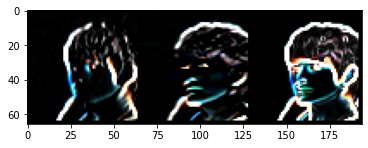

In [15]:
sample_sobeled = apply_sobel(sample_single_batch)
sample_sobel_x = sample_sobeled[:,:3]
sample_sobel_y = sample_sobeled[:,3:]
show_samples(torch.cat((sample_sobel_x, sample_sobel_y, torch.pow(sample_sobel_x, 2) + torch.pow(sample_sobel_y, 2)), dim=0), 3)

In [16]:
training_loader = DataLoader(train_dataset, batch_size=TRAINING_PARAMS['batch_size'])
val_loader = DataLoader(val_dataset, batch_size=TRAINING_PARAMS['batch_size'])

In [17]:
# define encoder based on parameters
encoder = BiEncoder(
    # img_size, hidden_size, hidden_layers, encoding_size, encoding_layers=None, img_channels=3, dropout_rate=0.01
    (64, 64), 
    MODEL_PARAMS['encoder_hidden_size'], 
    MODEL_PARAMS['encoder_hidden_layers'],
    MODEL_PARAMS['encoding_size'],
    MODEL_PARAMS['encoding_layers'],
    dropout_rate=MODEL_PARAMS['encoder_dropout_rate']
).to(TRAINING_PARAMS['device'])

decoder = HDecoder(
    # image_size, encoding_dim, encoding_layers, hidden_size, img_channels=3, dropout_rate=0.1
    (64, 64), 
    MODEL_PARAMS['encoding_size'],
    MODEL_PARAMS['encoding_layers'],
    MODEL_PARAMS['decoder_hidden_size'],
    dropout_rate=MODEL_PARAMS['decoder_dropout_rate']
).to(TRAINING_PARAMS['device'])

#torchsummary.summary(encoder, (3, 64, 64))
# not summarizing decoder because 
#  (1) the functions signature of decoder's forward is not compatible with this function
#  (2) decoder is much smaller size


In [18]:
# load if pretrained model uploaded
if os.path.isfile('encoder.pt'):
  encoder.load_state_dict(torch.load('encoder.pt'))
  print('loading pre-trained encoder')
if os.path.isfile('decoder.pt'):
  decoder.load_state_dict(torch.load('decoder.pt'))
  print('loading pre-trained decoder')

In [19]:
optimizer = torch.optim.Adam(
              [
                {'params': encoder.parameters()},
                {'params': decoder.parameters()}
              ], 
              lr = TRAINING_PARAMS['lr']
            )

In [20]:
!rm -rf model_checkpoints*
!mkdir -p model_checkpoints

In [21]:
# training
print('using {0}'.format(TRAINING_PARAMS['device']))
for epoch in range(0, TRAINING_PARAMS['epochs']):
  print('epoch {0} / {1}'.format(epoch + 1, TRAINING_PARAMS['epochs']))

  encoder.train()
  decoder.train()
  train_reconstruct_errs = []
  train_elbo_errs = []
  train_fb_errs = []
  pg_bar = ProgressBar(len(training_loader), 100)
  pg_bar.print_init()
  for image_batch, label_batch in training_loader:
    optimizer.zero_grad()

    # predict the z's, and the reconstructed images
    image_batch, label_batch = image_batch.to(TRAINING_PARAMS['device']), label_batch.to(TRAINING_PARAMS['device'])
    encodings, mus, logvars, dmus, dlogvars, fb_diffs = encoder(image_batch)

    reconstructed_img, reconstruct_hist = decoder(encodings)

    # calculate individual losses
    recon_err = reconstruct_error_historywise(reconstruct_hist, label_batch, TRAINING_PARAMS['reconstruct_coes'])
    elbo_err = ELBO_KL(
      mus, 
      logvars, 
      dmus, 
      dlogvars 
    )
    fb_err = forward_backward_error_term(fb_diffs)
    
    # the training loss is a weighted sum of all defined losses
    loss = recon_err + elbo_err * TRAINING_PARAMS['elbo_coe'] + fb_err * TRAINING_PARAMS['forward_backward_error_coe']
    loss.backward()

    if TRAINING_PARAMS['device'] in ['cuda', 'cpu']:
      optimizer.step()
    else:
      xm.optimizer_step(optimizer)

    train_reconstruct_errs.append(recon_err.detach().cpu().numpy())
    train_elbo_errs.append(elbo_err.detach().cpu().numpy())
    train_fb_errs.append(fb_err.detach().cpu().numpy())
    # print(train_reconstruct_errs[-1], train_elbo_errs[-1])
    pg_bar.update(1)

  # calculate losses on validation set
  encoder.eval()
  decoder.eval()
  val_reconstrct_errs = []
  val_elbo_errs = []
  for val_img, val_label in val_loader:
    val_img, val_label = val_img.to(TRAINING_PARAMS['device']), val_label.to(TRAINING_PARAMS['device'])
    val_encodings, val_mus, val_logvars, val_dmus, val_dlogvars, _ = encoder(val_img)
    val_reconstructed_img, val_reconstruct_hist = decoder(val_encodings)
    
    val_recon_err = reconstruct_error_historywise(val_reconstruct_hist, val_label, TRAINING_PARAMS['reconstruct_coes'])
    val_elbo_err = ELBO_KL(
      val_mus, 
      val_logvars, 
      val_dmus, 
      val_dlogvars
    )
    val_reconstrct_errs.append(val_recon_err.detach().cpu().numpy())
    val_elbo_errs.append(val_elbo_err.detach().cpu().numpy())

    
  train_recon_mean_loss = np.mean(train_reconstruct_errs)
  train_elbo_mean_loss = np.mean(train_elbo_errs)
  train_fb_mean_err = np.mean(train_fb_errs)

  val_recon_mean_loss = np.mean(val_reconstrct_errs)
  val_elbo_mean_loss = np.mean(val_elbo_errs)
  # print training stats in this epoch and save checkpoints
  print()
  print('training reconstruct err', train_recon_mean_loss)
  print('training elbo err mean', train_elbo_mean_loss)
  print('training forward backward diff', train_fb_mean_err)
    
  print('validation reconstruct err', val_recon_mean_loss)
  print('validation elbo err mean', val_elbo_mean_loss)
  print()

  checkpoint_suffix = 'E{0}_recon_{1}_elbo_{2}'.format(     
      epoch+1,
      str(train_recon_mean_loss).replace('.', '_'),
      str(train_elbo_mean_loss).replace('.', '_')
  )
  torch.save(encoder.state_dict(), 'model_checkpoints/encoder_{0}.pt'.format(checkpoint_suffix))
  torch.save(decoder.state_dict(), 'model_checkpoints/decoder_{0}.pt'.format(checkpoint_suffix))

A streamkimeneten csak az utolsó 5000 sor látható.
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
0
1
2
0
1
2
0
1
2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


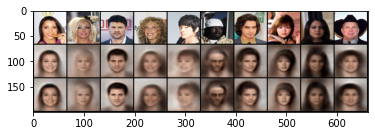

In [22]:
encoder.eval()
decoder.eval()
sample_batch = torch.cat([torch.reshape(train_dataset[idx][0], (1, *(train_dataset[idx][0].shape))) for idx in range(117, 127)], dim=0)
sample_encoding_no_hint, *_ = encoder(sample_batch.to(TRAINING_PARAMS['device']), 0.0)
sample_encoding_hint, *_ = encoder(sample_batch.to(TRAINING_PARAMS['device']), 1.0)
sample_prediction_no_hint, sample_pred_history_no_hint = decoder(sample_encoding_no_hint)
sample_prediction_hint, sample_pred_history_hint = decoder(sample_encoding_hint)
show_samples(torch.cat((sample_batch.to(TRAINING_PARAMS['device']), sample_prediction_no_hint, sample_prediction_hint), dim=0), 10)
encoder.train()
decoder.train()
print('')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


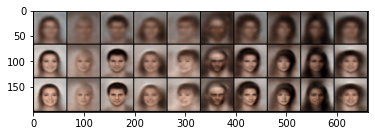

In [23]:
show_samples(torch.cat(sample_pred_history_no_hint, dim=0), 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


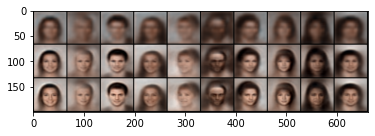

In [24]:
show_samples(torch.cat(sample_pred_history_hint, dim=0), 10)